This notebook is to:
1. Rebuild the ResNet50 network by Keras
2. Use the network to resolve an image classification problem of sign language
3. Compare our model with the pre-defined ResNet50 model

Data URL: https://www.kaggle.com/datamunge/sign-language-mnist#sign_mnist_train.zip

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import keras
from keras import layers
from keras.layers import Input, Flatten, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Dense, Conv2D, BatchNormalization, Activation
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load and visualize data 

In [2]:
def load_dataset():
    df_train =pd.read_csv('data/sign-language-digits-dataset/sign_mnist_train.csv')
    df_test = pd.read_csv('data/sign-language-digits-dataset/sign_mnist_test.csv')
    
    X_train = df_train.iloc[:, 1:].values
    y_train = df_train.iloc[:, 0].values

    X_test = df_test.iloc[:, 1:].values
    y_test = df_test.iloc[:, 0].values
    
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    
    y_train = to_categorical(y_train, num_classes=25)
    y_test = to_categorical(y_test, num_classes=25)
    
    print("X_train shape: {}".format(X_train.shape))
    print("X_test shape: {}".format(X_test.shape))

    print("y_train shape: {}".format(y_train.shape))
    print("y_test shape: {}".format(y_test.shape))
    
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_dataset()

X_train shape: (27455, 28, 28, 1)
X_test shape: (7172, 28, 28, 1)
y_train shape: (27455, 25)
y_test shape: (7172, 25)


In [4]:
def show_image(idx_train):
    label = np.argmax(y_train[idx_train])
    plt.imshow(X_train[idx_train, :, :, 0], cmap='Greys')
    plt.title('Class={}'.format(label))
    plt.axis('off')

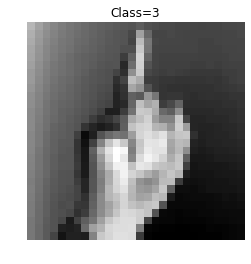

In [5]:
show_image(0)

# Build ResNet50

## Identity block: width and height unchanged

In [6]:
def identity_block(X, f, filters):
    # the short cut path
    X_shortcut = X
    
    F1, F2, F3 = filters
    
    # the main path
    ## the 1*1 conv unit
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    ## the f*f conv unit
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', 
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    ## another 1*1 conv unit
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # add two path, and pass the sum to relu activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Conv block: width = width/s and height = height/s

In [7]:
def conv_block(X, f, filters, s=2):
    F1, F2, F3 = filters
    
    # the shortcut path
    X_shortcut = X
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid',
                       kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # the main path
    ## the 1*1 conv unit
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', 
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    ## the f*f conv unit
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', 
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    ## another 1*1 conv unit
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    
    # Add the short path and the main apth
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Build the ResNet50
stage 1: **CONV2D -> BATCHNORM -> RELU -> MAXPOOL**

stage 2: **-> CONVBLOCK -> IDBLOCK\*2**

stage 3: **-> CONVBLOCK -> IDBLOCK\*3**

stage 4: **-> CONVBLOCK -> IDBLOCK\*5**

stage 5: **-> CONVBLOCK -> IDBLOCK\*2**

stage 6: **-> AVGPOOL -> TOPLAYER**

In [8]:
def ResNet50(input_shape, classes):
    # input
    X_input = Input(input_shape)
    
    # zero-padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='Valid',
               kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # stage 2
    X = conv_block(X, f=3, filters=[64, 64, 256], s=1) #s=1 so width and height unchange
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])
    
    # stage 3
    X = conv_block(X, f=3, filters=[128, 128, 512], s=2) # s=2 so width and height halves
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    
    # stage 4
    X = conv_block(X, f=3, filters=[256, 256, 1024], s=2) # s=2 so width and height halves
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    
    # stage 5
    X = conv_block(X, f=3, filters=[512, 512, 2024], s=2) # =2 so width and height halves
    
    # stage 6
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform())(X)
    
    # build model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [9]:
model = ResNet50(input_shape=X_train.shape[1:], classes=25)

# Training 

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history  = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=[X_test, y_test])

Train on 27455 samples, validate on 7172 samples
Epoch 1/40
27455/27455 [==============================] - 34s 1ms/step - loss: 1.0758 - acc: 0.7301 - val_loss: 1.9318 - val_acc: 0.5074
Epoch 2/40
27455/27455 [==============================] - 20s 711us/step - loss: 0.0814 - acc: 0.9735 - val_loss: 1.5146 - val_acc: 0.7441
Epoch 3/40
27455/27455 [==============================] - 20s 711us/step - loss: 0.0361 - acc: 0.9888 - val_loss: 2.4322 - val_acc: 0.5464
Epoch 4/40
27455/27455 [==============================] - 20s 713us/step - loss: 0.0442 - acc: 0.9873 - val_loss: 1.8774 - val_acc: 0.5722
Epoch 5/40
27455/27455 [==============================] - 20s 714us/step - loss: 0.0363 - acc: 0.9898 - val_loss: 2.3296 - val_acc: 0.5611
Epoch 6/40
27455/27455 [==============================] - 20s 716us/step - loss: 0.0191 - acc: 0.9945 - val_loss: 1.5343 - val_acc: 0.7111
Epoch 7/40
27455/27455 [==============================] - 20s 716us/step - loss: 0.0212 - acc: 0.9933 - val_loss: 3.333

In [12]:
def plot_learning_curve(history):
    epoch = history.epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(epoch, loss, color='red', label='Training')
    ax[0].plot(epoch, val_loss, color='blue', label='Validation')
    ax[0].set_title('Learning Curve (Loss)')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(epoch, acc, color='red', label='Training')
    ax[1].plot(epoch, val_acc, color='blue', label='Validation')
    ax[1].set_title('Learning Curve (Accuracy)')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

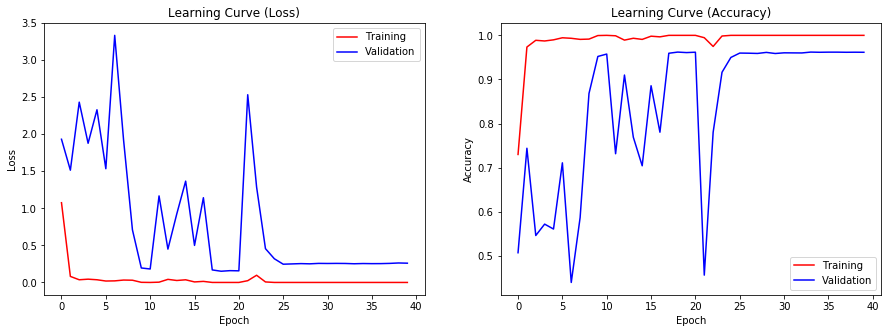

In [13]:
plot_learning_curve(history)

# Evaluation

In [14]:
evaluation = model.evaluate(X_test, y_test, verbose=1)

prob_test = model.predict(X_test, verbose=1)

pred_test = (prob_test > 0.5).astype(np.int)

print('Test loss: {}'.format(evaluation[0]))
print('Test accuracy: {}'.format(evaluation[1]))

7172/7172 [==============================] - 3s 481us/step
Test loss: 0.2597837222372262
Test accuracy: 0.9616564417177914


In [43]:
def show_test(X_test, y_test, pred_test):
    n = 14
    choice = np.random.choice(X_test.shape[0], n, replace=False)
    fig, ax = plt.subplots(2, n//2, figsize=(20, 4))
    ax = ax.ravel()
    for idx, ax_i in enumerate(ax):
        ax_i.imshow(X_test[choice[idx], :, :, 0], cmap='Greys')
        true = str(np.argmax(y_test[choice[idx]]))
        pred = str(np.argmax(pred_test[choice[idx]]))
        ax_i.set_title('True is {} and prediction is {}'.format(true, pred))
        ax_i.grid(False)
    plt.tight_layout()

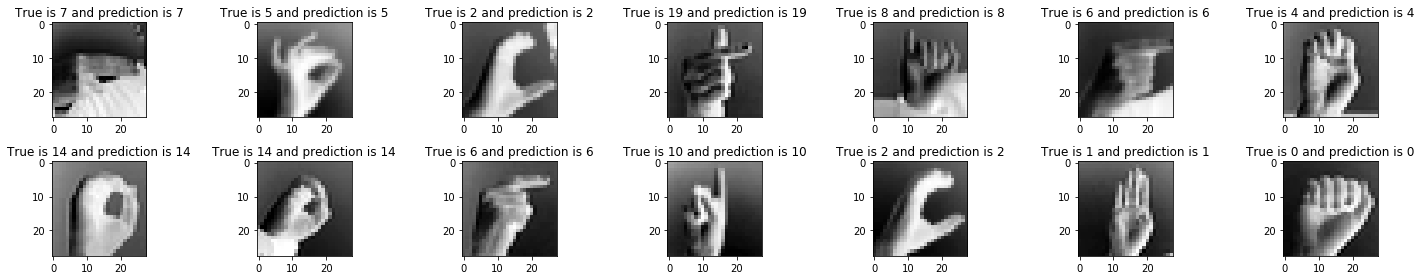

In [44]:
show_test(X_test, y_test, pred_test)